This tutorial follow the same steps of fastai course lecture 11 on translation http://course.fast.ai/lessons/lesson11.html

see: https://github.com/fastai/fastai/blob/master/courses/dl2/translate.ipynb

It showcasess the seq2seq, seq2seq with attention and transformer models of quicknlp and how
they can be used without using the quicknlp modeldata objects


In [1]:
# first data is downloaded
#!wget http://www.statmt.org/wmt10/training-giga-fren.tar

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import re
import pickle
from fastai.text import Tokenizer, SortishSampler, SortSampler
from fastai.core import partition_by_cores, A, to_gpu, V, to_np
from fastai.dataset import Dataset, DataLoader, ModelData
import numpy as np
from collections import Counter, defaultdict
from quicknlp.data.learners import EncoderDecoderLearner
from quicknlp.models import Seq2Seq, Seq2SeqAttention, Transformer
from quicknlp.data.model_helpers import S2SModel
import torch.nn as nn
from functools import partial
from torch.optim import Adam

In [4]:
PATH = Path('dataset/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [ ]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [ ]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [ ]:
qs[:5], len(qs)

In [ ]:
en_qs,fr_qs = zip(*qs)

In [ ]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [ ]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [ ]:
en_tok[0], fr_tok[0]

In [ ]:
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

In [ ]:
keep = np.array([len(o)<30 for o in en_tok])

In [ ]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [ ]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [ ]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [ ]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk_')
    stoi = defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [ ]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [5]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [6]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [ ]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

In [ ]:
! pip install git+https://github.com/facebookresearch/fastText.git

In [ ]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [ ]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

In [ ]:
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [ ]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [ ]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [21]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [22]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [23]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

In [24]:
fr_vecs = np.stack(list(fr_vecd.values()))
fr_vecs.mean(),fr_vecs.std()

(-0.0014966384, 0.2718286)

## Model data

In [7]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(29, 33)

In [8]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [9]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], [0] + self.y[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [10]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

In [11]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [12]:
bs=125

In [13]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [14]:
class S2SDataLoader(DataLoader):
    def get_batch(self, indices):
        res = self.np_collate([self.dataset[i] for i in indices])
        if self.transpose:   res[0], res[1] = res[0].T, res[1].T
        if self.transpose_y: res[2] = res[2].T
        return res

In [15]:
trn_dl = S2SDataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = S2SDataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [16]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y), len(t)) for x,y,t in its]

[(31, 12, 11), (21, 8, 7), (21, 9, 8), (33, 14, 13), (33, 22, 21)]

In [17]:
type(its[0][0]), type(its[0][1]), type(its[0][2])

(torch.cuda.LongTensor, torch.cuda.LongTensor, torch.cuda.LongTensor)

In [18]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [25]:
input_embedding = create_emb(fr_vecd, fr_itos, dim_fr_vec)
output_embedding = create_emb(en_vecd, en_itos, dim_en_vec)

24793 ['de', 'les', '-', 'la', 'le']
17573 ['the', 'what', 'of', 'to', 'is']


In [26]:
input_embedding.weight.size()

torch.Size([24793, 300])

In [20]:
seq2seqmodel = Seq2Seq(
            ntoken=[input_embedding.weight.size(0), output_embedding.weight.size(0)],
            emb_sz=[input_embedding.weight.size(1), output_embedding.weight.size(1)],
            nhid=256,
            nlayers=2,
            pad_token=1,
            eos_token=2,
            max_tokens=34,
            cell_type='gru',
            dropout_e= [0.15, 0.],
            dropout_i= 0.,
            dropout_d = 0.35,
            wdrop = 0.,
            dropouth = [0.25, 0.1],
            bidir=False
        )

NameError: name 'input_embedding' is not defined

In [ ]:
# assign the embedding matrices
seq2seqmodel.encoder.embedding_layer.encoder_with_dropout.embed.weight = input_embedding.weight
seq2seqmodel.decoder.embedding_layer.encoder_with_dropout.embed.weight = output_embedding.weight
seq2seqmodel.decoder.projection_layer.layers[-1].weight = output_embedding.weight

In [ ]:
opt_fn = partial(Adam, betas=(0.8, 0.99))
model = S2SModel(to_gpu(seq2seqmodel))
learn = EncoderDecoderLearner(md, model, opt_fn=opt_fn)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), teacher_forcing=0)

In [ ]:
learn.save('initial')

In [ ]:
learn.load('initial')

In [ ]:
*x,y = next(iter(val_dl))
learn.model.eval()
probs = learn.model(*V(x),num_beams=1)[0]

preds=to_np(probs[...,0])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[0][:,i] if o > 2]))
    print("--->")
    print(' '.join([en_itos[o] for o in preds[:,i] if o > 2]))
    print("====")
    print(' '.join([en_itos[o] for o in y[:,i] if o > 2]))
    print("******")

In [ ]:
to_np(probs).shape, y.shape, preds.shape

# Teacher Forcing

In [ ]:
seq2seqmodel = Seq2Seq(
            ntoken=[input_embedding.weight.size(0), output_embedding.weight.size(0)],
            emb_sz=[input_embedding.weight.size(1), output_embedding.weight.size(1)],
            nhid=256,
            nlayers=2,
            pad_token=1,
            eos_token=2,
            max_tokens=34,
            cell_type='gru',
            dropout_e =[0.15, 0.],
            dropout_i = 0.,
            wdrop = 0.,
            dropouth = [0.25, 0.1],
            bidir=False
        )

In [ ]:
# assign the embedding matrices
seq2seqmodel.encoder.embedding_layer.encoder_with_dropout.embed.weight = input_embedding.weight
seq2seqmodel.decoder.embedding_layer.encoder_with_dropout.embed.weight = output_embedding.weight
seq2seqmodel.decoder.projection_layer.layers[-1].weight = output_embedding.weight

In [ ]:
opt_fn = partial(Adam, betas=(0.8, 0.99))
model = S2SModel(to_gpu(seq2seqmodel))
learn = EncoderDecoderLearner(md, model, opt_fn=opt_fn)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), teacher_forcing=10)

In [ ]:
learn.save('teacherforcing')

In [ ]:
learn.load('teacherforcing')

In [ ]:
*x,y = next(iter(val_dl))
learn.model.eval()
probs = learn.model(*V(x),num_beams=1)[0]

preds=to_np(probs[...,0])
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[0][:,i] if o > 2]))
    print("--->")
    print(' '.join([en_itos[o] for o in preds[:,i] if o > 2]))
    print("====")
    print(' '.join([en_itos[o] for o in y[:,i] if o > 2]))
    print("******")

# Bidir

In [ ]:
seq2seqmodel = Seq2Seq(
            ntoken=[input_embedding.weight.size(0), output_embedding.weight.size(0)],
            emb_sz=[input_embedding.weight.size(1), output_embedding.weight.size(1)],
            nhid=256,
            nlayers=2,
            pad_token=1,
            eos_token=2,
            max_tokens=34,
            cell_type='gru',
            dropout_e =[0.15, 0.],
            dropout_i = 0.,
            wdrop = 0.,
            dropouth = [0.25, 0.1],
            bidir=True
        )

In [ ]:
# assign the embedding matrices
seq2seqmodel.encoder.embedding_layer.encoder_with_dropout.embed.weight = input_embedding.weight
seq2seqmodel.decoder.embedding_layer.encoder_with_dropout.embed.weight = output_embedding.weight
seq2seqmodel.decoder.projection_layer.layers[-1].weight = output_embedding.weight

In [ ]:
opt_fn = partial(Adam, betas=(0.8, 0.99))
model = S2SModel(to_gpu(seq2seqmodel))
learn = EncoderDecoderLearner(md, model, opt_fn=opt_fn)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), teacher_forcing=10)

In [ ]:
learn.save('bidirtf')

In [ ]:
learn.load('bidirtf')

In [ ]:
*x,y = next(iter(val_dl))
learn.model.eval()
probs = learn.model(*V(x),num_beams=1)[0]

preds=to_np(probs[...,0])
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[0][:,i] if o > 2]))
    print("--->")
    print(' '.join([en_itos[o] for o in preds[:,i] if o > 2]))
    print("====")
    print(' '.join([en_itos[o] for o in y[:,i] if o > 2]))
    print("******")

# Attention Model

In [47]:
seq2seqmodel = Seq2SeqAttention(
            ntoken=[input_embedding.weight.size(0), output_embedding.weight.size(0)],
            emb_sz=[input_embedding.weight.size(1), output_embedding.weight.size(1)],
            nhid=256,
            nlayers=2,
            pad_token=1,
            eos_token=2,
            max_tokens=34,
            cell_type='gru',
            dropout_e =[0.15, 0.],
            dropout_i = [0.2, 0.1],
            wdrop = 0.,
            dropouth = [0.25, 0.1],
            att_nhid=256,
            bidir=True
        )

In [48]:
# assign the embedding matrices
seq2seqmodel.encoder.embedding_layer.encoder_with_dropout.embed.weight = input_embedding.weight
seq2seqmodel.decoder.embedding_layer.encoder_with_dropout.embed.weight = output_embedding.weight
seq2seqmodel.decoder.projection_layer.projection2.weight = output_embedding.weight

In [49]:
opt_fn = partial(Adam, betas=(0.8, 0.99))
model = S2SModel(to_gpu(seq2seqmodel))
learn = EncoderDecoderLearner(md, model, opt_fn=opt_fn)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▋   | 240/362 [00:22<00:11, 10.50it/s, loss=29.6]

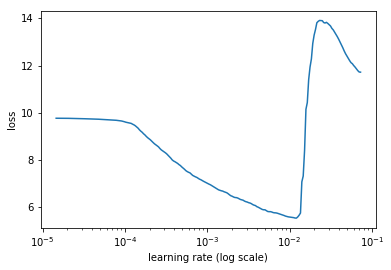

In [46]:
learn.lr_find()
learn.sched.plot()

In [50]:
lr=2e-3

In [52]:
learn.fit(lr, 1, cycle_len=10, use_clr=(20,10), teacher_forcing=None)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   
    0      3.172091   2.998817  
    1      3.325651   2.861877  
    2      3.199467   2.815038  
    3      3.109225   2.788246  
    4      3.048564   2.724706  
    5      2.99165    2.699182  
    6      2.899239   2.667038  
    7      2.798418   2.640215  
    8      2.766275   2.632312  
    9      2.734976   2.619201  



[array([2.6192])]

In [38]:
learn.save('attention')

In [39]:
learn.load('attention')

In [42]:
*x,y = next(iter(val_dl))
learn.model.eval()
probs = learn.model(*V(x),num_beams=1)[0]

preds=to_np(probs[...,0])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[0][:,i] if o > 2]))
    print("--->")
    print(' '.join([en_itos[o] for o in preds[:,i] if o > 2]))
    print("====")
    print(' '.join([en_itos[o] for o in y[:,i] if o > 2]))
    print("******")

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ?
--->
what components of the different of be be be be , and what data and be be ?
====
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ?
******
le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ?
--->
what is the minister minister the minister minister a a mental mental health , mental mental , and ? ?
====
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ?
******
quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ?
--->
what are the consequences of the of non -

# Transformer Model

In [ ]:
seq2seqmodel = Transformer(
            ntoken=[input_embedding.weight.size(0), output_embedding.weight.size(0)],
            emb_size=300,
            nhid=512,
            nlayers=6,
            pad_token=1,
            eos_token=2,
            max_tokens=34,
            dropout=0.1,
        )

In [ ]:
# assign the embedding matrices
seq2seqmodel.encoder.embedding_layer.layers[0].embedding.weight = input_embedding.weight
seq2seqmodel.decoder.embedding_layer.layers[0].embedding.weight = output_embedding.weight
seq2seqmodel.decoder.projection_layer.layers[-1].weight = output_embedding.weight

In [ ]:
opt_fn = partial(Adam, betas=(0.8, 0.99))
model = S2SModel(to_gpu(seq2seqmodel))
learn = EncoderDecoderLearner(md, model, opt_fn=opt_fn)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=2e-3

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

In [ ]:
learn.save("transformer")

In [ ]:
learn.load('transformer')

In [ ]:
*x,y = next(iter(val_dl))
learn.model.eval()
probs = learn.model(*V(x),num_beams=1)[0]

preds=to_np(probs[...,0])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[0][:,i] if o > 2]))
    print("--->")
    print(' '.join([en_itos[o] for o in preds[:,i] if o > 2]))
    print("====")
    print(' '.join([en_itos[o] for o in y[:,i] if o > 2]))
    print("******")